# Long-Short Strategy, Part 4: How to interpret GBM results

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. `model_interpretation` (this noteboook): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Understanding why a model predicts a certain outcome is very important for several reasons, including trust, actionability, accountability, and debugging. 

Insights into the nonlinear relationship between features and the outcome uncovered by the model, as well as interactions among features, are also of value when the goal is to learn more about the underlying drivers of the phenomenon under study.

## Imports & Settings

In [1]:
%matplotlib inline

from pathlib import Path
import warnings
from random import randint
from itertools import product

import numpy as np
import pandas as pd

import shap
import lightgbm as lgb
#from sklearn.inspection import (plot_partial_dependence, 
#                                partial_dependence)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice
np.random.seed(42)

In [61]:
DATA_STORE = Path('data/assets.h5')
DATA_STORE_ITEM = 'engineered_features_trimmed'

## Retrieve best model parameters

In [4]:
tiporf=0 # 0 para LGBM

The results used below are created by the notebooks [gbm_trading_signals](05_gbm_trading_signals.ipynb).

In [6]:
params = pd.read_hdf('data.h5', 'best_params')
params


train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    500.00
boost_rounds         10.00
Name: 39, dtype: float64

In [8]:
with pd.HDFStore('data.h5') as store:
    best_params = store['best_params']
    if tiporf==0:
        best_params = store['best_params']

In [9]:
best_params

train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    500.00
boost_rounds         10.00
Name: 39, dtype: float64

## Get Training Data

In [69]:
data = pd.read_hdf(DATA_STORE,DATA_STORE_ITEM).sort_index()#modificado
data0=data.copy()
data = data.loc[idx[:, '2019':'2024'], :]

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3421 entries, ('IYR', Timestamp('2019-01-06 00:00:00')) to ('XLY', Timestamp('2024-12-15 00:00:00'))
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   return_1w                                     3421 non-null   float64
 1   sector                                        3421 non-null   object 
 2   target_1w                                     3410 non-null   float64
 3   return_2w                                     3421 non-null   float64
 4   return_52w                                    3421 non-null   float64
 5   Mkt-RF                                        3421 non-null   float64
 6   SMB                                           3421 non-null   float64
 7   HML                                           3421 non-null   float64
 8   RMW                                           3421 non-null  

In [71]:
#miramos las exposiciones a los factores
resultado = data.groupby(level=0).last().iloc[:, 6:11]
print(resultado)

             SMB       HML       RMW       CMA  momentum_2
ticker                                                    
IYR    -0.777619  1.974940 -1.714827  2.685024   -0.715402
VOX    -2.227222 -1.040808 -3.443085  1.082708    1.213891
XLB    -4.057215  6.675119 -1.716710  5.318887   -0.933192
XLE    -4.722860  8.648361  1.535056 -4.037880   -1.251139
XLF    -0.929003  5.551506 -6.612354 -0.745859   -0.521985
XLI    -0.787674  2.501670 -2.770071  2.767907   -0.789937
XLK    -0.984247  0.710927 -2.640646 -2.107122    0.798180
XLP    -3.485116  1.567505 -5.659233  6.728633   -0.614567
XLU    -1.053207  4.116497 -4.639236  0.665696   -1.094424
XLV    -2.363224 -1.767154 -6.856169  6.870963   -0.576136
XLY     1.185825  1.879458 -4.336978 -1.725603    1.265339


## Tratamiento NaN

In [18]:
#completamos con los valores del periodo anterior, para evitar que el último dato apareza nan
data= data.fillna(method='ffill')

## Create Binary Data

In [19]:
dates = sorted(data.index.get_level_values('date').unique())

In [20]:
train_dates = dates[-int(best_params.train_length+best_params.test_length):-int(best_params.test_length)]

In [23]:
data_copia=data.copy()

In [24]:
data = data.loc[idx[:, train_dates], :]

In [25]:
labels = sorted(data.filter(like='target').columns)#modificado
features = data.columns.difference(labels).tolist()

In [27]:
lookahead = 1
label = 'target_1w'#modificado

In [28]:
categoricals = ['sector']#modificado 'year','month'

In [29]:
data.columns[:60]


Index(['return_1w', 'sector', 'target_1w', 'return_2w', 'return_52w', 'Mkt-RF',
       'SMB', 'HML', 'RMW', 'CMA', 'momentum_2', 'year', 'month',
       'return_1w_t-3', 'return_1w_t-4', 'return_1w_t-5', 'return_1w_t-6',
       'recession', 'yield_curve', 'corp_oas', 'sentiment', 'oil',
       'weekjobclaims', 'retail_sales_percent', 'new_homes', 'recession_diff',
       'yield_curve_diff', 'corp_oas_diff', 'sentiment_diff', 'empleo_diff',
       'oil_diff', 'inflacion_diff', 'leading_diff', 'vix_diff',
       'weekjobclaims_diff', 'retail_sales_percent_diff', '1y_yield_diff',
       'tot_bank_credit_diff', 'lumber_diff', 'cotton_diff', 'wheat_diff',
       'corn_diff', 'coffee_diff', 'energy_price_diff', 'copper_diff',
       'natural_gas_diff', 'business_inventory_diff', 'corporate_profits_diff',
       'semiconductor_electronics_manufacturing_diff',
       'consumer_price_index_diff', 'M2_money_supply_diff',
       '10y_real_interest_rate_diff', 'new_homes_diff',
       'streaming_m

In [30]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [31]:
lgb_train = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

## Train LightGBM Model

In [32]:
params = dict(boosting='gbdt', objective='regression', verbose=-1)
train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

params.update(best_params.loc[train_params].to_dict())
for p in ['min_data_in_leaf','max_depth']:
        params[p] = int(params[p])

lgb_model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=int(best_params.boost_rounds))

for feature in categoricals:
    data_copia[feature] = pd.factorize(data_copia[feature], sort=True)[0]

lgb_model.predict(data_copia.loc['XLK',features].tail(1))

In [35]:
best_params

train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    500.00
boost_rounds         10.00
Name: 39, dtype: float64

In [36]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.01,
 'num_leaves': 4,
 'feature_fraction': 0.95,
 'min_data_in_leaf': 500}

In [40]:
data_copia.loc['XLK'].tail(1)

,return_1w,sector,target_1w,return_2w,return_52w,Mkt-RF,SMB,HML,RMW,CMA,...,natural_gas_diff,business_inventory_diff,corporate_profits_diff,semiconductor_electronics_manufacturing_diff,consumer_price_index_diff,M2_money_supply_diff,10y_real_interest_rate_diff,new_homes_diff,streaming_media_consumption_diff,gold_diff
date,,,,,,,,,,,,,,,,,,,,,
2024-12-15,-0.362481,XLK,-0.362481,0.435699,3.090264,6.286863,-0.984247,0.710927,-2.640646,-2.107122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compute Feature Importance

A common approach to gaining insights into the predictions made by tree ensemble methods, such as gradient boosting or random forest models, is to attribute feature importance values to each input variable. These feature importance values can be computed on an individual basis for a single prediction or globally for an entire dataset (that is, for all samples) to gain a higher-level perspective on how the model makes predictions.

There are three primary ways to compute global feature importance values:
- Gain: This classic approach introduced by Leo Breiman in 1984 uses the total reduction of loss or impurity contributed by all splits for a given feature. The motivation is largely heuristic, but it is a commonly used method to select features.
- Split count: This is an alternative approach that counts how often a feature is used to make a split decision, based on the selection of features for this purpose based on the resultant information gain.
- Permutation: This approach randomly permutes the feature values in a test set and measures how much the model's error changes, assuming that an important feature should create a large increase in the prediction error. Different permutation choices lead to alternative implementations of this basic approach.

All gradient boosting implementations provide feature-importance scores after training as a model attribute. The `lightGBM` library provides five versions, as shown in the following list:
- total_gain and gain as its average per split
- total_cover as the number of samples per split when a feature was used
- weight as the split count from preceding values

These values are available using the trained model's .feature_importance() method with the corresponding importance_type parameter. For the best performing XGBoost model, the results are as follows (the total measures have a correlation of 0.8, as do cover and total_cover):

While the indicators for different months and years dominate, the most recent 1m return is the second-most important feature from a total_gain perspective, and is used frequently according to the weight measure, but produces low average gains as it is applied to relatively few instances on average).

In [45]:
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi/fi.sum()

In [46]:
feature_importance = (get_feature_importance(lgb_model).to_frame('Split').
                      join(get_feature_importance(lgb_model, 'gain').to_frame('Gain')))

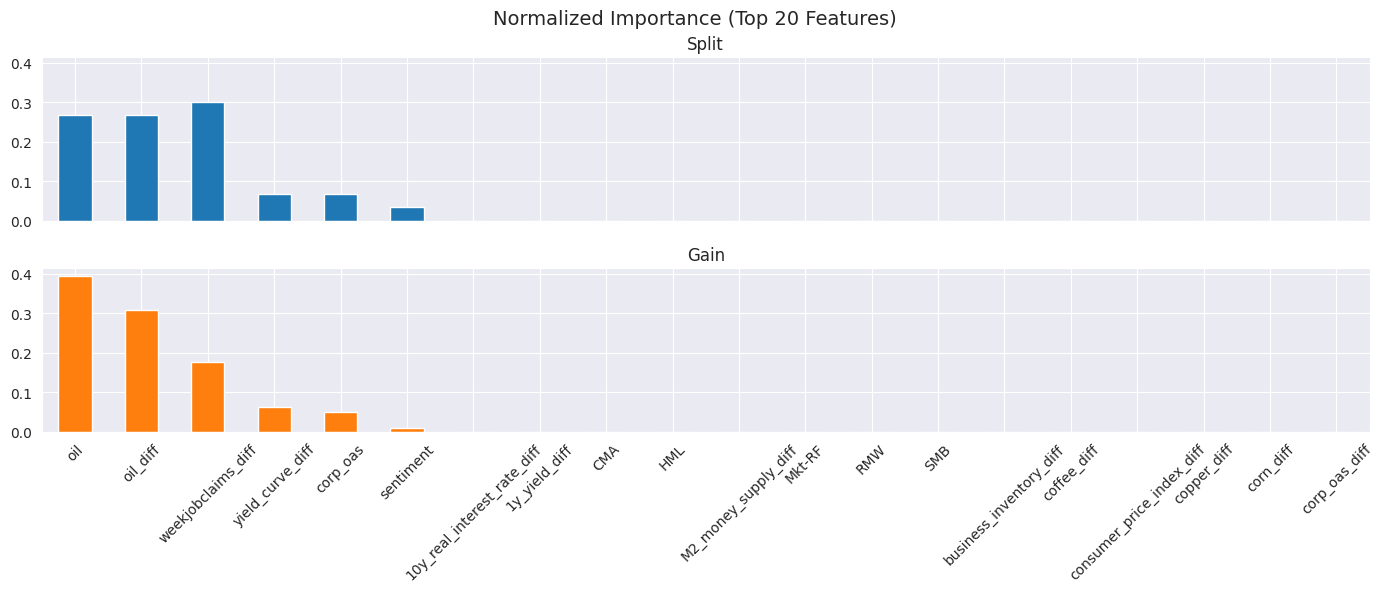

In [79]:
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True,
      layout=(2, 1),
      figsize=(14, 6),
      legend=False,
      sharey=True,
      rot=45))
plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9);

In [48]:
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False))

,Split,Gain
oil,0.266667,0.394675
oil_diff,0.266667,0.308822
weekjobclaims_diff,0.300000,0.176257
yield_curve_diff,0.066667,0.062442
corp_oas,0.066667,0.049285
sentiment,0.033333,0.008519
10y_real_interest_rate_diff,0.000000,0.000000
1y_yield_diff,0.000000,0.000000
CMA,0.000000,0.000000
HML,0.000000,0.000000


## SHAP Values

At the 2017 NIPS conference, Scott Lundberg and Su-In Lee from the University of Washington presented a new and more accurate approach to explaining the contribution of individual features to the output of tree ensemble models called [SHapley Additive exPlanations](https://github.com/slundberg/shap), or SHAP values.

This new algorithm departs from the observation that feature-attribution methods for tree ensembles, such as the ones we looked at earlier, are inconsistent—that is, a change in a model that increases the impact of a feature on the output can lower the importance values for this feature.

SHAP values unify ideas from collaborative game theory and local explanations, and have been shown to be theoretically optimal, consistent, and locally accurate based on expectations. Most importantly, Lundberg and Lee have developed an algorithm that manages to reduce the complexity of computing these model-agnostic, additive feature-attribution methods from O(TLDM) to O(TLD2), where T and M are the number of trees and features, respectively, and D and L are the maximum depth and number of leaves across the trees. 

This important innovation permits the explanation of predictions from previously intractable models with thousands of trees and features in a fraction of a second. An open source implementation became available in late 2017 and is compatible with XGBoost, LightGBM, CatBoost, and sklearn tree models. 

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.

### Summary Plot

To get a high-level overview of the feature importance across a number of samples, there are two ways to plot the SHAP values: a simple average across all samples that resembles the global feature-importance measures computed previously (as shown in the second plot), or a scatter graph to display the impact of every feature for every sample (as shown in first plot). 

The scatter plot sorts features by their total SHAP values across all samples, and then shows how each feature impacts the model output as measured by the SHAP value as a function of the feature's value, represented by its color, where red represents high and blue represents low values relative to the feature's range.

They are very straightforward to produce using a trained model of a compatible library and matching input data, as shown in the following code:

In [52]:
X = data[features].sample(n=len(data))#modificado

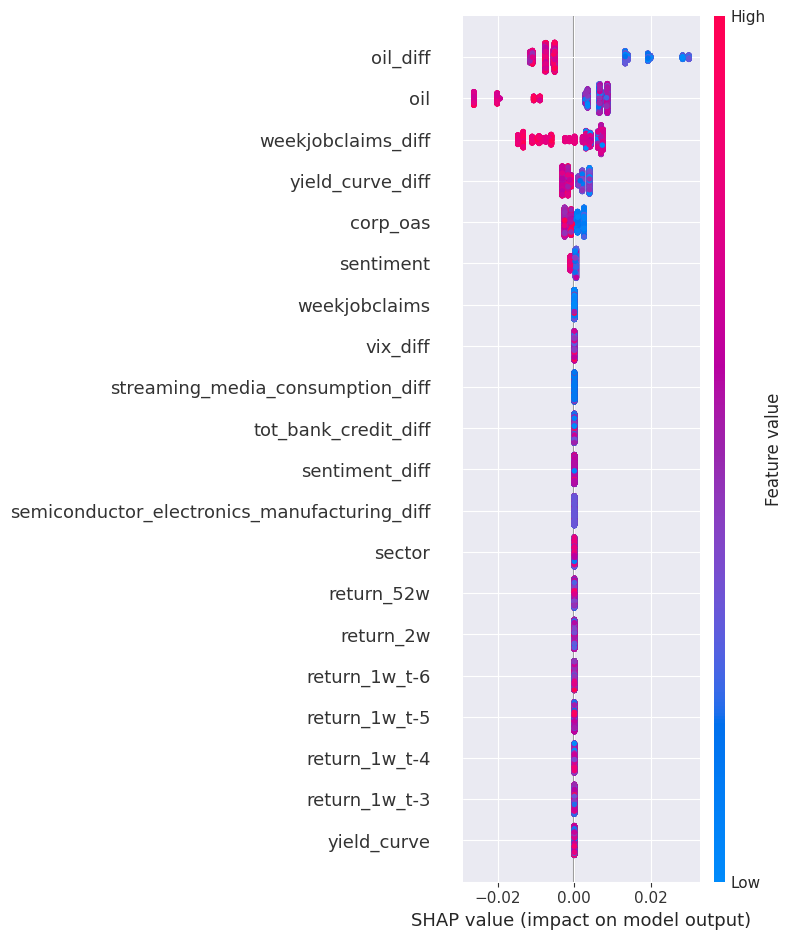

In [54]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();

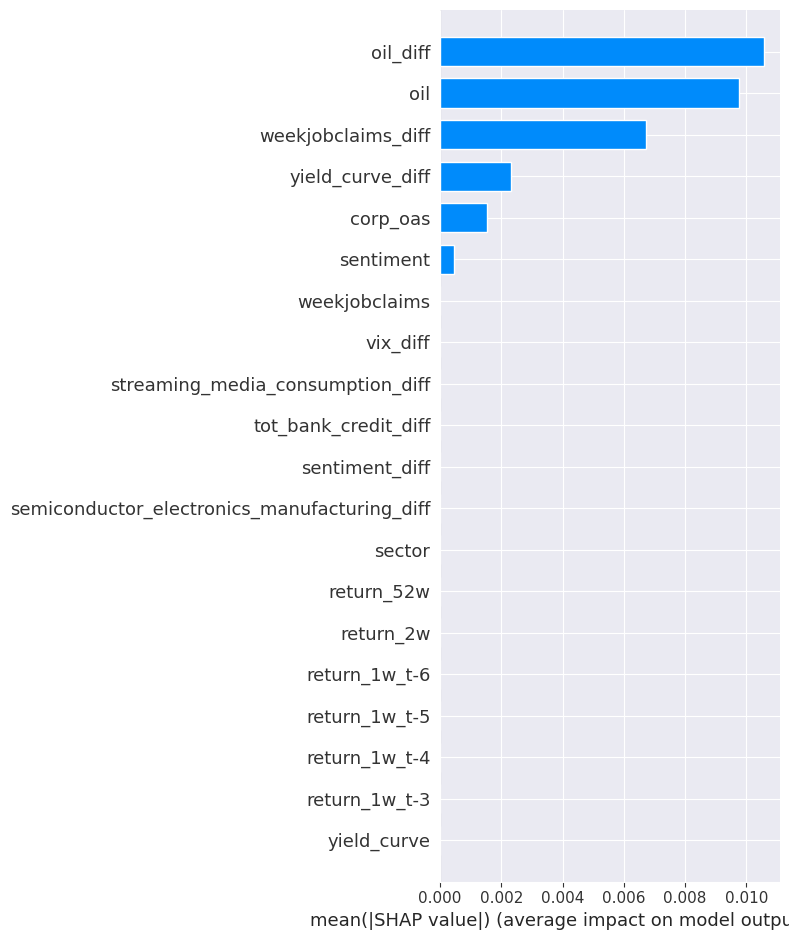

In [55]:
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.tight_layout();

### Feature Interaction

### Force Plots

The following force plot shows the cumulative impact of various features and their values on the model output, which in this case was 0.6, quite a bit higher than the base value of 0.13 (the average model output over the provided dataset). 

Features highlighted in red increase the output. The month being October is the most important feature and increases the output from 0.338 to 0.537, whereas the year being 2017 reduces the output. 

Hence, we obtain a detailed breakdown of how the model arrived at a specific prediction:

In [56]:
i = randint(0, len(X))
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

We can also compute force plots for numerous data points or predictions at a time and use a clustered visualization to gain insights into how prevalent certain influence patterns are across the dataset. 

The following plot shows the force plots for the first 1,000 observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation. 

The implementation uses hierarchical agglomerative clustering of data points on the feature SHAP values to identify these patterns, and displays the result interactively for exploratory analysis, as shown in the following code:

In [57]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000])

### Interaction Plot

Lastly, SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. The shap.dependence_plot  can be defined as follows. It displays how different values for 1-month returns (on the x axis) affect the outcome (SHAP value on the y axis), differentiated by 3-month returns:

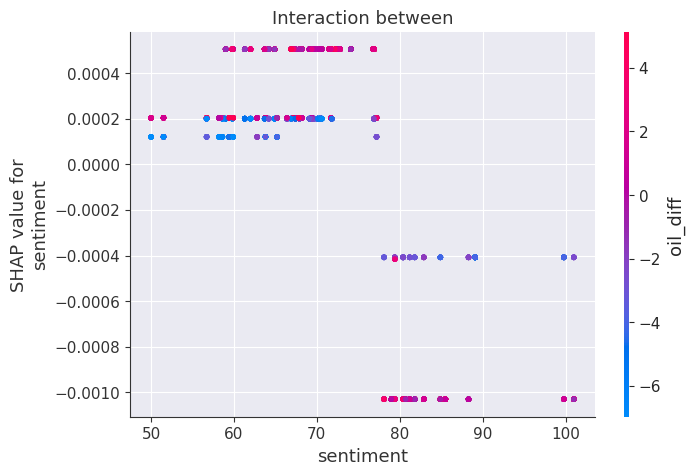

In [58]:
shap.dependence_plot(ind='sentiment',
                     shap_values=shap_values,
                     features=X,
                     interaction_index='oil_diff',
                     title='Interaction between')

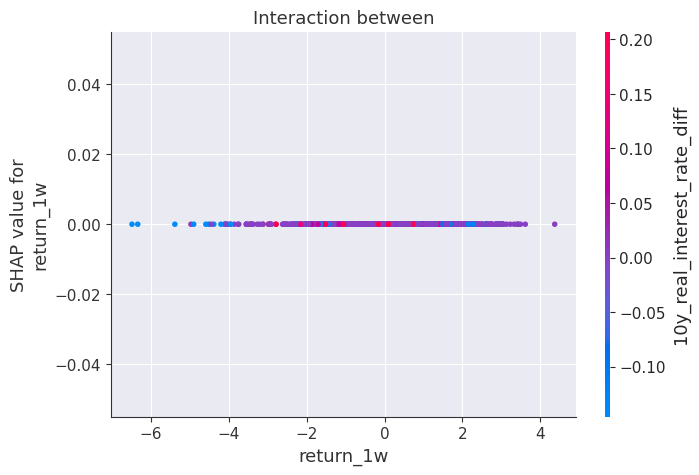

In [59]:
shap.dependence_plot(ind='return_1w',
                     shap_values=shap_values,
                     features=X,
                     #interaction_index='return_9m',
                     title='Interaction between')

In [60]:
shap.dependence_plot(ind='eu_hy_oas_diff',
                     shap_values=shap_values,
                     features=X,
                     #interaction_index='return_9m',
                     title='Interaction between')

ValueError: Could not find feature named: eu_hy_oas_diff

In [60]:
shap.dependence_plot(ind='return_52w',
                     shap_values=shap_values,
                     features=X,
                     #interaction_index='return_9m',
                     title='Interaction between')

ValueError: Could not find feature named: return_52w

In [61]:
shap.dependence_plot(ind='vixoil',
                     shap_values=shap_values,
                     features=X,
                     #interaction_index='return_9m',
                     title='Interaction between')

ValueError: Could not find feature named: vixoil

In [62]:
shap.dependence_plot(ind='RMW',
                     shap_values=shap_values,
                     features=X,
                     #interaction_index='return_9m',
                     title='Interaction between')

ValueError: Could not find feature named: RMW

SHAP values provide granular feature attribution at the level of each individual prediction, and enable much richer inspection of complex models through (interactive) visualization. The SHAP summary scatterplot displayed at the beginning of this section offers much more differentiated insights than a global feature-importance bar chart. Force plots of individual clustered predictions allow for more detailed analysis, while SHAP dependence plots capture interaction effects and, as a result, provide more accurate and detailed results than partial dependence plots.

The limitations of SHAP values, as with any current feature-importance measure, concern the attribution of the influence of variables that are highly correlated because their similar impact could be broken down in arbitrary ways.